```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook reads the data from the rank histogram experiments and
creates the rank histogram.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Rank histogram


This notebook reads the data from the rank histogram experiments and
creates the rank histogram.


## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation
from SWESimulators import DoubleJetCase
from SWESimulators import DataAssimilationUtils as dautils

In [2]:
%cuda_context_handler gpu_ctx
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

In [3]:
host = os.uname()[1] 
if host in ["r740-5hdn2s2-ag-gcompute", "r740-5hcv2s2-ag-gcompute", "r740-dsxm2t2-ag-gcompute", "r740-dsws2t2-ag-gcompute"]:
    host = "ppi"

### Define functions for plotting

In [4]:
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,3), interior=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
        
    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, ax=None):
    drifter_positions = observations.get_drifter_position(t)

    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax = plt.subplot(111)
        emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
        ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:tomato red'
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)

    
def days_to_sec(days):
    return days*24*60*60

def sec_to_days(days):
    return days/(24*60*60)


def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))



In [5]:
def file_filter(path_to_dir, ext=None, prefix=None, abspath=True):
    if isinstance(path_to_dir,str):
        filtered_files = os.listdir(path_to_dir)
        if prefix:
            filtered_files = list(file for file in filtered_files if file.startswith(prefix))
        if ext:
            filtered_files = list(file for file in filtered_files if file.endswith(ext))
        if abspath:
            filtered_files= list(os.path.join(path_to_dir, file)  for file in filtered_files)
    else:
        filtered_files = []
        for single_path_to_dir in path_to_dir:
            filtered_files.extend(file_filter(single_path_to_dir, ext, prefix, abspath))

    filtered_files.sort()
    return filtered_files

# Reading the truth

Loading the truth to see which parts of the domain that can be relevant. 

We use buoys in order to assimilate the same data points for each round.

In [6]:
if host == "ppi":
    truth_path = os.path.abspath('/lustre/storeB/users/florianb/data/true_state/')
elif host == "havvarsel":
    truth_path = os.path.abspath('/sintef/data/true_state/')
else:
    truth_path = os.path.abspath('Give path here')
assert len(os.listdir(truth_path)) == 4 or len(os.listdir(truth_path)) == 3, \
"Truth folder has wrong number of files"


In [7]:
truth_state_filename = os.path.join(truth_path, "double_jet_case_truth.nc")
observations_filename = os.path.join(truth_path, "drifter_observations.pickle")

truth_reader = SimReader.SimNetCDFReader(truth_state_filename)

observation_type = dautils.ObservationType.StaticBuoys
nx = truth_reader.get('nx')
ny = truth_reader.get('ny')
dx = truth_reader.get('dx')
dy = truth_reader.get('dy')
domain_size_x = nx*dx
domain_size_y = ny*dy

observations = Observation.Observation(observation_type=observation_type,
                                       domain_size_x=domain_size_x, domain_size_y=domain_size_y,
                                       nx=nx, ny=ny)
observations.read_pickle(observations_filename)
observations.setBuoyReadingArea('all')

x_index = 100


## Reading the experiments

In [8]:
# INPUT!!!
# Directory (or list of directories) containing the experiment files
dataset_path = [os.path.join('/sintef/rank_histogram_experiments/rank_histogram_experiments_2022_03_07-16_56_25_sparseLETKF')] 

# dataset_path = [os.path.join('/lustre/storeB/users/florianb/rank_histogram_experiments/rank_histogram_experiments_2021_05_31-15_11_31/'),
#                 os.path.join('/lustre/storeB/users/florianb/rank_histogram_experiments/rank_histogram_experiments_2021_06_01-06_18_26/'),
#                 os.path.join('/lustre/storeB/users/florianb/rank_histogram_experiments/rank_histogram_experiments_2021_06_01-16_51_59/')] # Collection of LETKF runs


# Folder for figures
# Generated in the first experiment folder
if isinstance(dataset_path,str):
    fig_path = os.path.join(dataset_path, 'figures_' + timestamp)
else:
    fig_path = os.path.join(dataset_path[0], 'figures_' + timestamp)
if not os.path.exists(fig_path):
    os.mkdir(fig_path)
    print('created figure folder')
    print(fig_path)

# INPUT!!!
# Time for which rank histograms are generated
rank_histogram_time = 1

# Filtering all files containing the relevant experiment information 
rank_histogram_files = file_filter(dataset_path, 
                                   ext='npz', 
                                   prefix='hour_' + str(rank_histogram_time).zfill(3))

print(len(rank_histogram_files))

created figure folder
/sintef/rank_histogram_experiments/rank_histogram_experiments_2022_03_07-16_56_25_sparseLETKF/figures_2022_03_09-17_33_57
1000


In [9]:
# Read the first obtained time values
# (The first stored time after the spin-up)
first_experiment = np.load(rank_histogram_files[0])
t_rank = float(first_experiment['t'])
print(t_rank) # usually 3d + 1h in seconds


262800.0


262800.0 1
(240, 2)
[100   0]
[100  25]
[100  50]
[100  75]
[100 100]
[100 125]
[100 150]
[100 175]
[100 200]
[100 225]
[100 250]
[100 275]


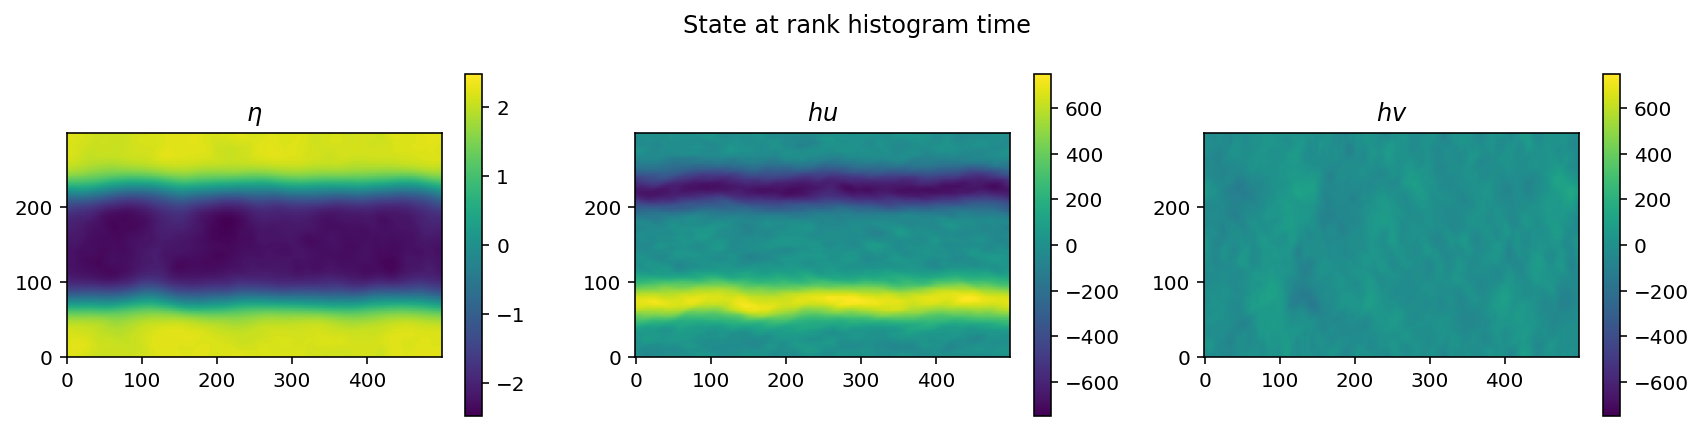

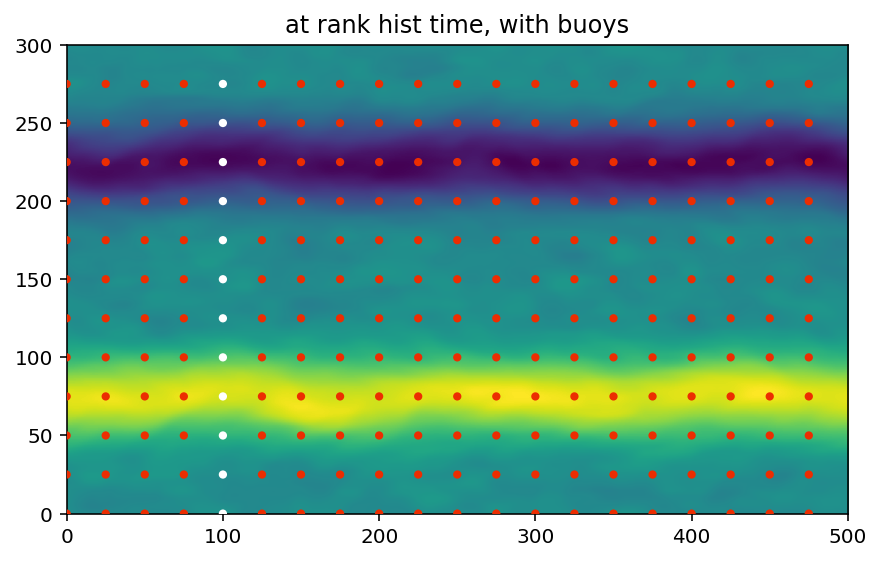

In [10]:
t_rank_index = truth_time_step(t_rank)
eta_rank, hu_rank, hv_rank, t = truth_reader.getTimeStep(t_rank_index)
print(t, t_rank_index)
imshow3(eta_rank, hu_rank, hv_rank, title='State at rank histogram time')

buoy_cell_indices = observations.buoy_indices[observations.read_buoy, :]
print(buoy_cell_indices.shape)

buoy_y = np.zeros(12)
buoy_x = 100
bouy_y_map = [False]*ny

fig = plt.figure(figsize=(7,7))

ax = plt.subplot(111)
ax.imshow(hu_rank, origin="lower", extent=[0, nx, 0, ny])

buoy_index = 0
for i in range(buoy_cell_indices.shape[0]):
    color = 'xkcd:tomato red'
    if buoy_cell_indices[i,0] == buoy_x:
        print(buoy_cell_indices[i,:])
        color = 'xkcd:white'
        buoy_y[buoy_index] = buoy_cell_indices[i,1]
        buoy_index += 1
        bouy_y_map[buoy_cell_indices[i,1]] = True
    circ_end = matplotlib.patches.Circle((buoy_cell_indices[i,0], buoy_cell_indices[i,1]),
                                         2, fill=True, zorder=10, color=color)
    ax.add_patch(circ_end)
    
    
plt.title('at rank hist time, with buoys')
plt.savefig(os.path.join(fig_path, 'truth_with_buoys.png'))
plt.savefig(os.path.join(fig_path, 'truth_with_buoys.pdf'))

262800 3.0416666666666665
type of observations.buoy_indices:  int32
direct positions (type float32)
262800.0 1
found observations! Now, let's make some plusses!
(240, 4)
[  38.89990616   42.13750458    8.41128635   33.21056366  242.45774841
  317.43325806  656.51531982  683.22869873  343.11776733  225.85896301
   20.91111565   29.5985775    21.86622047  -28.33454514   21.51555634
   -1.44069421 -266.36340332 -349.0954895  -684.17730713 -663.26904297
 -318.11514282 -257.60473633  -35.07796478  -34.35728073]


<Figure size 864x288 with 0 Axes>

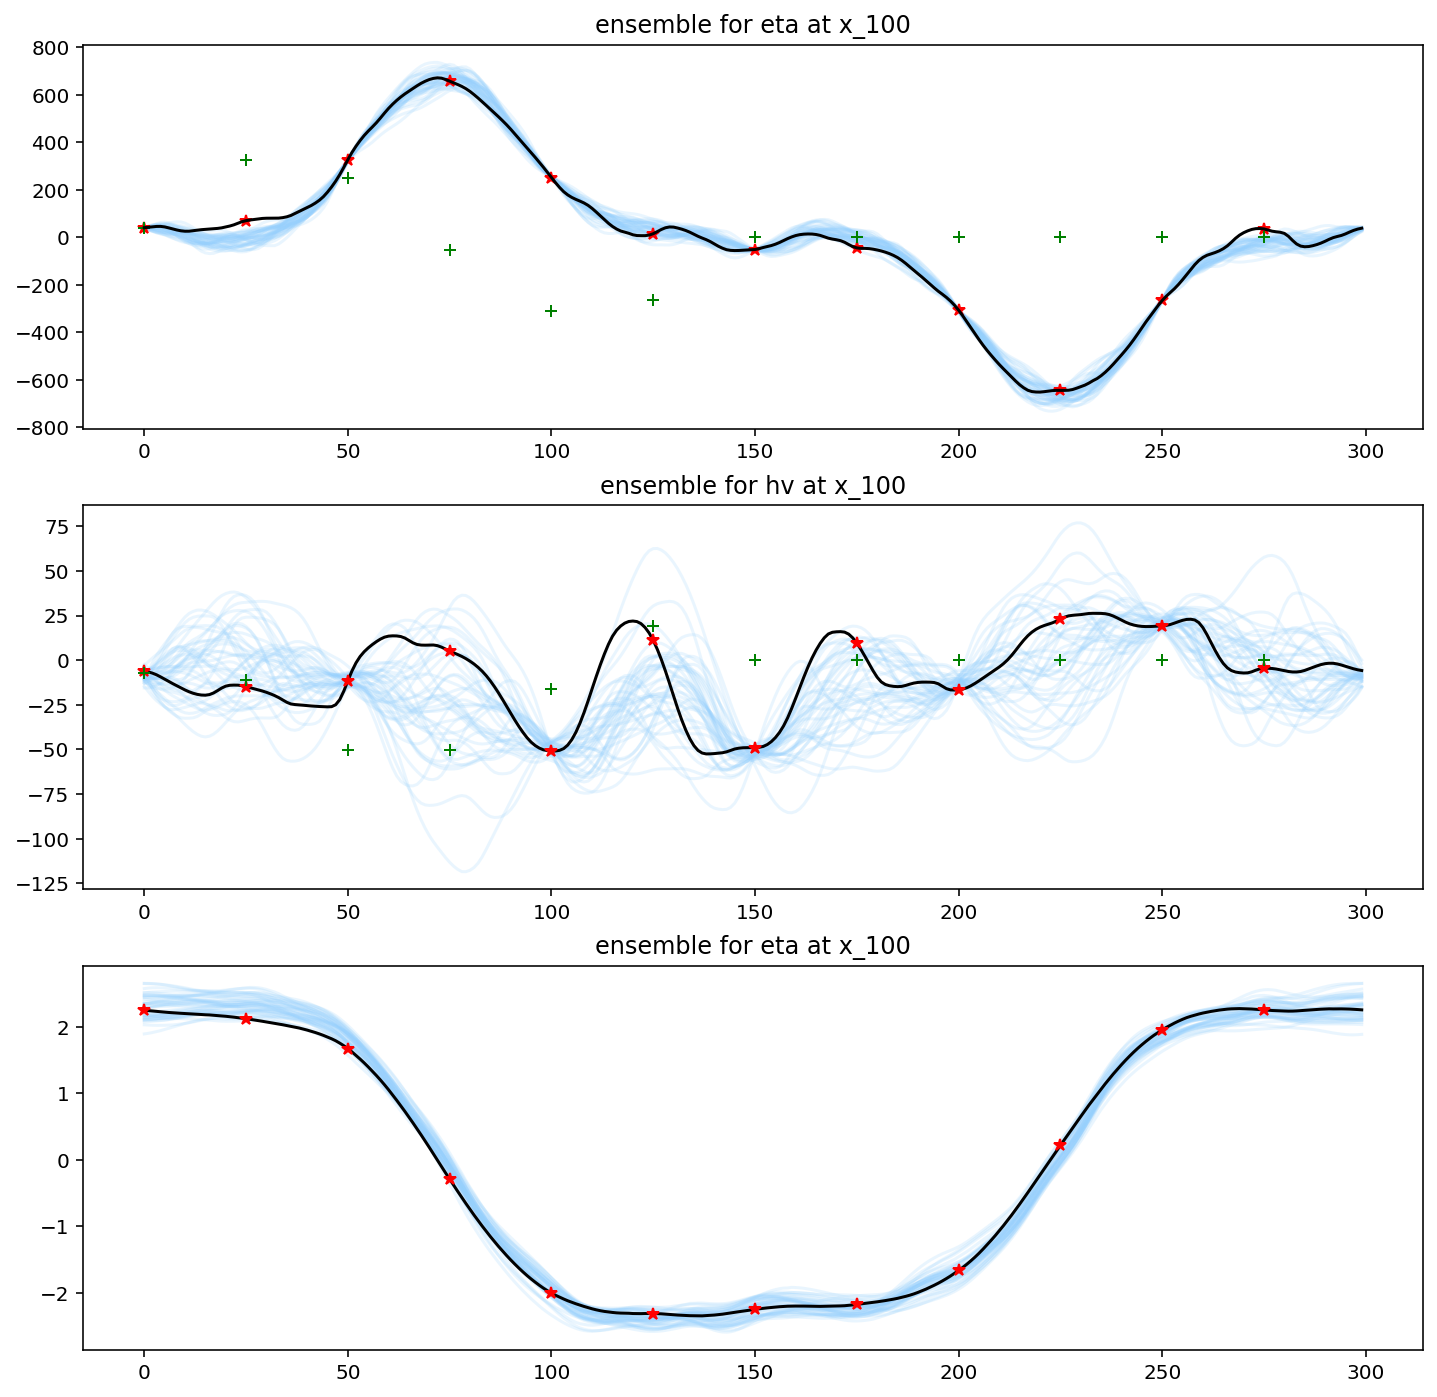

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

In [11]:
#FIXME: Right waterdepth needed
observed_values = observations.get_observation(t_rank, 60.0)

rounded_t = round(t_rank)
t_rank_index_obs = observations.obs_df[observations.obs_df[observations.time_key]==rounded_t].index.values[0]

print(rounded_t, sec_to_days(rounded_t))
print('type of observations.buoy_indices: ', observations.buoy_indices.dtype)

print('direct positions (type ' + str(observations.buoy_positions.copy()[observations.read_buoy, :].dtype) + ')')
#print(observations.buoy_positions.copy()[observations.read_buoy, :])
#print('direct hu hv:')
#print(observations.obs_df.iloc[index][observations.columns[2]][observations.read_buoy, :])

eta_rank, hu_rank, hv_rank, t = truth_reader.getTimeStep(t_rank_index)
print(t, t_rank_index)
eta_true = eta_rank[:, buoy_x]
hu_true = hu_rank[:, buoy_x]
hv_true = hv_rank[:, buoy_x]

if 'true_hu' in first_experiment.files:
    eta_true = first_experiment['true_eta']
    hu_true = first_experiment['true_hu']
    hv_true = first_experiment['true_hv']
    
if 'observations' in first_experiment.files:
    print("found observations! Now, let's make some plusses!")
    experiment_observations = first_experiment['observations']
    hu_obs = np.zeros(12)
    hv_obs = np.zeros(12)
    y_index = 0
    for obs in experiment_observations:
        if obs[0] == (buoy_x + 0.5)*truth_reader.get('dx'):
            #print(np.floor(obs[1]/truth_reader.get('dy')))
            hu_obs[y_index] = obs[2]
            hv_obs[y_index] = obs[3]
            y_index += 1
#        print(obs.shape)

print(observed_values.shape)
print(observed_values[4::10, 2])
#print(observed_values[4::10, 2]-hu_rank[bouy_y_map, buoy_x])

# Plotting the cross section at the chosen buoy locations:
fig = plt.figure(figsize=(12,4))
fig, axs = plt.subplots(3, 1, figsize=(12,12))


axs[0].plot(np.arange(ny), hu_true, 'k', zorder=10)
first_hu = first_experiment['hu']
for p in range(first_hu.shape[1]):
    axs[0].plot(np.arange(ny), first_hu[:,p], color='xkcd:light blue', alpha=0.2)
axs[0].plot(buoy_y, hu_true[bouy_y_map], 'r*')
if 'observations' in first_experiment.files:
    axs[0].plot(buoy_y, hu_obs, 'g+')
axs[0].set_title('ensemble for eta at x_100')


fig = plt.figure(figsize=(12,4))
first_hv = first_experiment['hv']
for p in range(first_hu.shape[1]):
    axs[1].plot(np.arange(ny), first_hv[:,p], color='xkcd:light blue', alpha=0.2)
axs[1].plot(np.arange(ny), hv_true, 'k')
axs[1].plot(buoy_y, hv_true[bouy_y_map], 'r*')
if 'observations' in first_experiment.files:
    axs[1].plot(buoy_y, hv_obs, 'g+')
axs[1].set_title('ensemble for hv at x_100')


fig = plt.figure(figsize=(12,4))
first_eta = first_experiment['eta']
for p in range(first_hu.shape[1]):
    axs[2].plot(np.arange(ny), first_eta[:,p], color='xkcd:light blue', alpha=0.2)
axs[2].plot(np.arange(ny), eta_true, 'k')
axs[2].plot(buoy_y, eta_true[bouy_y_map], 'r*')
axs[2].set_title('ensemble for eta at x_100')

plt.savefig(os.path.join(fig_path, 'ensemble_cross_section_x_100.png'))
plt.savefig(os.path.join(fig_path, 'ensemble_cross_section_x_100.pdf'))


# Rank histogram experiment

Rank histograms are an established way to test the quality of data assimilation methods (see reference Hamill 2001 from Skauvold et al). Our rank histogram experiment is based on the buoy experiment in which we observe the western half of the domain with $R = \mathrm{diag}(1)$ and assimilation windows of five minutes.  The ensemble size is sat to $N_e = 40$. For each experiment we store the cross section at $x = 100.5 \Delta x$ (center of the 100'the cell in $x$-direction).

In [12]:
experiment = np.load(rank_histogram_files[0])
experiment.files

['t',
 'eta',
 'hu',
 'hv',
 'true_eta',
 'true_hu',
 'true_hv',
 'observations',
 'observation_variance']

In [13]:
def rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=True, perturb_truth=True, make_paper_figure=False):
    
    rank_histograms = []

    rank_histogram_files = file_filter(dataset_path, 
                                   ext='npz', 
                                   prefix='hour_' + str(hour).zfill(3))

    print('Creating rank histogram from ' + str(len(rank_histogram_files)) + ' files')
    
    # Time in seconds is read from first file
    first_experiment = np.load(rank_histogram_files[0])
    t_rank = float(first_experiment['t'])
    
    # Index in the truth corresponding to the provided time
    t_rank_index = truth_time_step(t_rank)
    
    
    num_rank_experiments = len(rank_histogram_files)
    Ne = 40
    buoy_x = 100 # Index of buoy

    # Read the truth. Only use if there are no truth in the result file.
    common_true_eta, common_true_hu, common_true_hv, true_t = truth_reader.getTimeStep(t_rank_index)
    ny = truth_reader.get('ny')

    buckets_hu  = np.zeros((ny, Ne+1))
    buckets_hv  = np.zeros((ny, Ne+1))
    buckets_eta = np.zeros((ny, Ne+1))

    interesting_y_indices = interesting_y_indices.astype(np.int32) # [0, 25, 50, 70, 75, 80, 100, 125, 150, 175]
    
    common_true_eta = common_true_eta[:,buoy_x]
    common_true_hu  = common_true_hu[:, buoy_x]
    common_true_hv  = common_true_hv[:, buoy_x]

    exp_no = 0
    for file in rank_histogram_files:
        #print(file)
        result = np.load(file)
        eta = result['eta'] 
        hu  = result['hu']
        hv  = result['hv'] 
        t = result['t']
        assert(true_t == t)
        observation_variance = result["observation_variance"]

        true_eta, true_hu, true_hv = None, None, None
        if 'true_eta' in result.files:
            true_eta = result['true_eta']
            true_hu  = result['true_hu']
            true_hv  = result['true_hv']
        else:
            true_eta = common_true_eta
            true_hu  = common_true_hu
            true_hv  = common_true_hv

        if perturb_truth:
            true_hu = true_hu + np.random.normal(scale=np.sqrt(observation_variance), size=300)
            true_hv = true_hv + np.random.normal(scale=np.sqrt(observation_variance), size=300)

        for y in interesting_y_indices:
            if perturb:
                ensemble_hu  = hu[y, :] + np.random.normal(scale=1, size=Ne)
                ensemble_hv  = hv[y, :] + np.random.normal(scale=1, size=Ne)
            else:
                ensemble_hu  = hu[y, :] 
                ensemble_hv  = hv[y, :] 
            ensemble_eta = eta[y, :] 

            ensemble_hu.sort()
            ensemble_hv.sort()
            ensemble_eta.sort()

            bucket_hu  = np.searchsorted(ensemble_hu, true_hu[y])
            bucket_hv  = np.searchsorted(ensemble_hv, true_hv[y])
            bucket_eta = np.searchsorted(ensemble_eta, true_eta[y])

            buckets_hu[y, bucket_hu] += 1
            buckets_hv[y, bucket_hv] += 1
            buckets_eta[y, bucket_eta] += 1

        if num_rank_experiments > 99:
            if (exp_no % int(num_rank_experiments/100) == 0):
                print('.'+str(exp_no)+'.', end='')
        exp_no += 1

    accumulated_eta = np.zeros_like(buckets_eta[0,:])
    accumulated_hu  = np.zeros_like(buckets_hu[0,:])
    accumulated_hv  = np.zeros_like(buckets_hv[0,:])
    
    # Plot results
    for y in interesting_y_indices:
        
        accumulated_eta += buckets_eta[y,:]
        accumulated_hu  += buckets_hu[y,:]
        accumulated_hv  += buckets_hv[y,:]
        
        fig, axs = plt.subplots(1, 3, figsize=(15,3))

        axs[0].bar(np.arange(Ne+1), buckets_eta[y,:], width=1)
        axs[0].set_title('eta at cell (100, '+str(y)+')')

        axs[1].bar(np.arange(Ne+1), buckets_hu[y,:], width=1)
        axs[1].set_title('hu at cell (100, '+str(y)+')')

        axs[2].bar(np.arange(Ne+1), buckets_hv[y,:], width=1)
        axs[2].set_title('hv at cell (100, '+str(y)+')')
        
        plt.suptitle('Rank histogram at time hour ' + str(hour), fontsize=15)
        #plt.tight_layout()
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
        filename = 'rank_histogram_y_'+str(y).zfill(3)+'_hour_'+str(hour).zfill(3)+'.pdf'
        plt.savefig(os.path.join(fig_path, filename))
        plt.savefig(os.path.join(fig_path, filename).replace('.pdf', '.png'))
        
        rank_histogram_data = {'y_cell': y,
                               'rank_hist_hu': buckets_hu[y,:],
                               'rank_hist_hv': buckets_hv[y,:]}
        rank_histograms.append(rank_histogram_data)
    
    fig, axs = plt.subplots(1, 3, figsize=(15,3))

    axs[0].bar(np.arange(Ne+1), accumulated_eta, width=1)
    axs[0].set_title('accumulated eta')

    axs[1].bar(np.arange(Ne+1), accumulated_hu, width=1)
    axs[1].set_title('accumulated hu')

    axs[2].bar(np.arange(Ne+1), accumulated_hv, width=1)
    axs[2].set_title('accumulated hv')

    plt.suptitle('Accumulated rank histogram at time hour ' + str(hour), fontsize=15)
    #plt.tight_layout()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    str_interesting_y_indices= str(interesting_y_indices).replace('[  ','').replace(']','').replace('  ', ' ').replace(' ', '_')
    filename = 'rank_histogram_accumulated_'+str_interesting_y_indices+'_hour_'+str(hour).zfill(3)+'.pdf'
    plt.savefig(os.path.join(fig_path, filename))
    plt.savefig(os.path.join(fig_path, filename).replace('.pdf', '.png'))
    
    rank_histogram_data = {'y_cell': 'all',
                           'rank_hist_hu': accumulated_hu,
                           'rank_hist_hv': accumulated_hv}
    rank_histograms.append(rank_histogram_data)
    return rank_histograms

['/sintef/rank_histogram_experiments/rank_histogram_experiments_2022_03_07-16_56_25_sparseLETKF']
Creating rank histogram from 1000 files
.0..10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990.

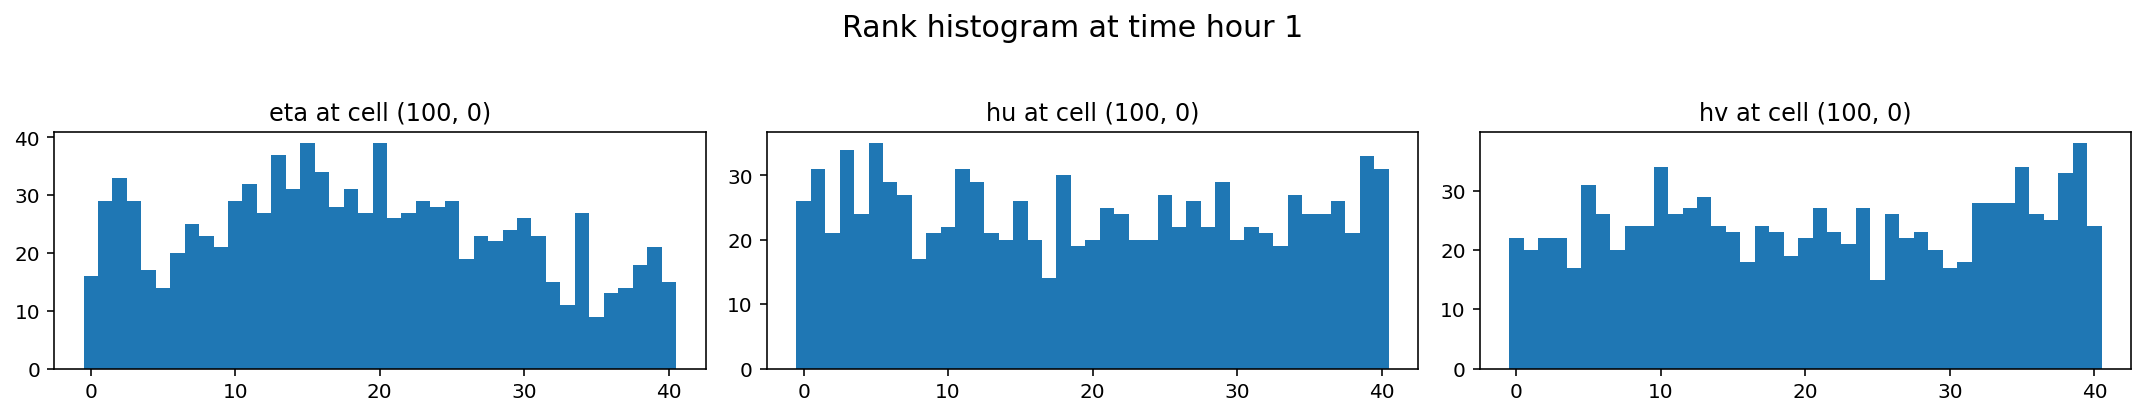

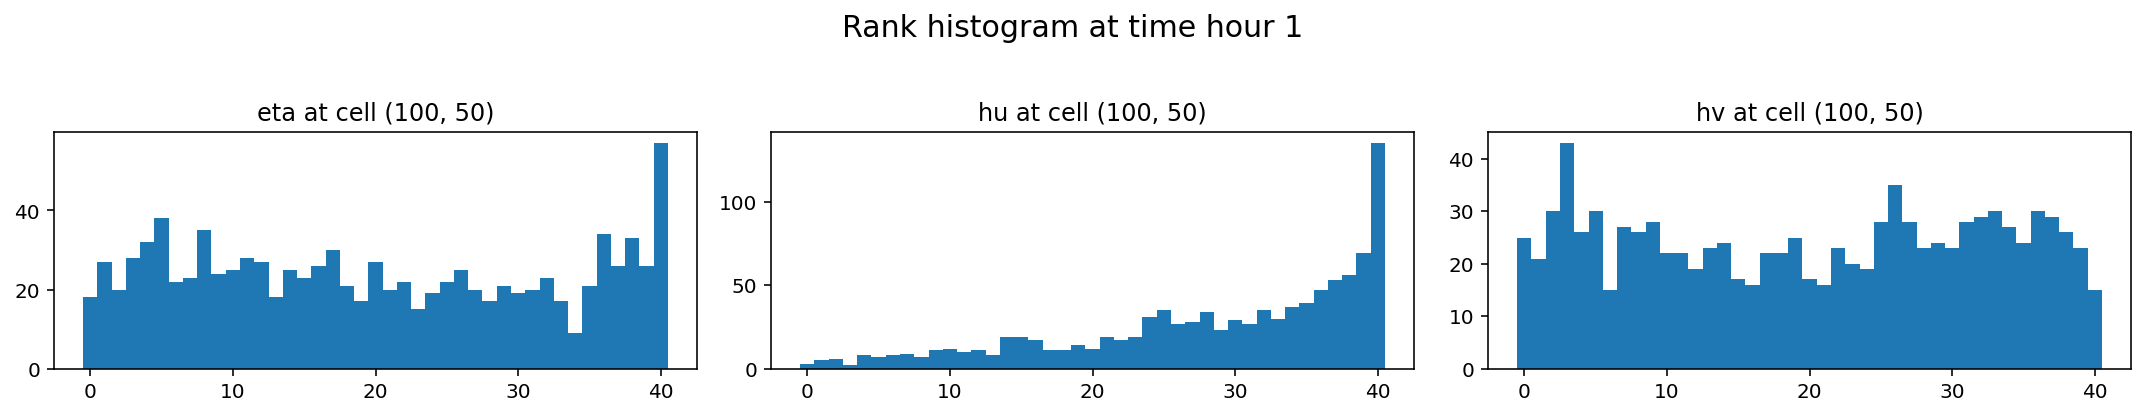

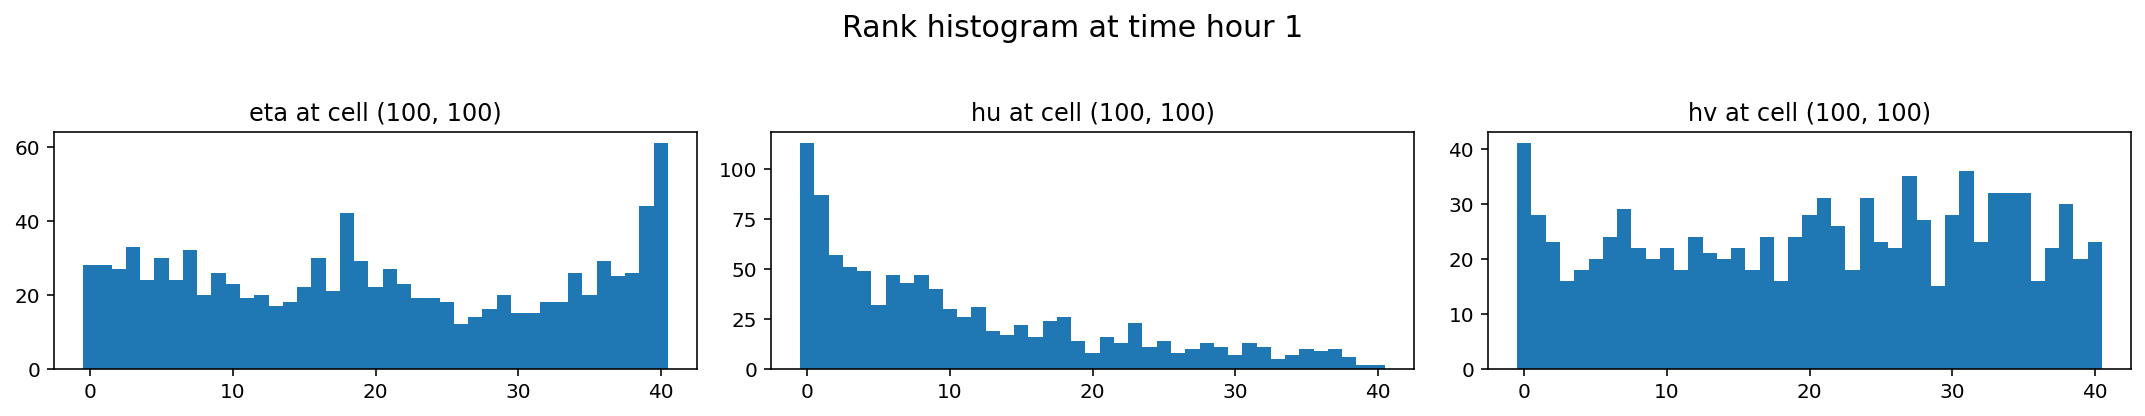

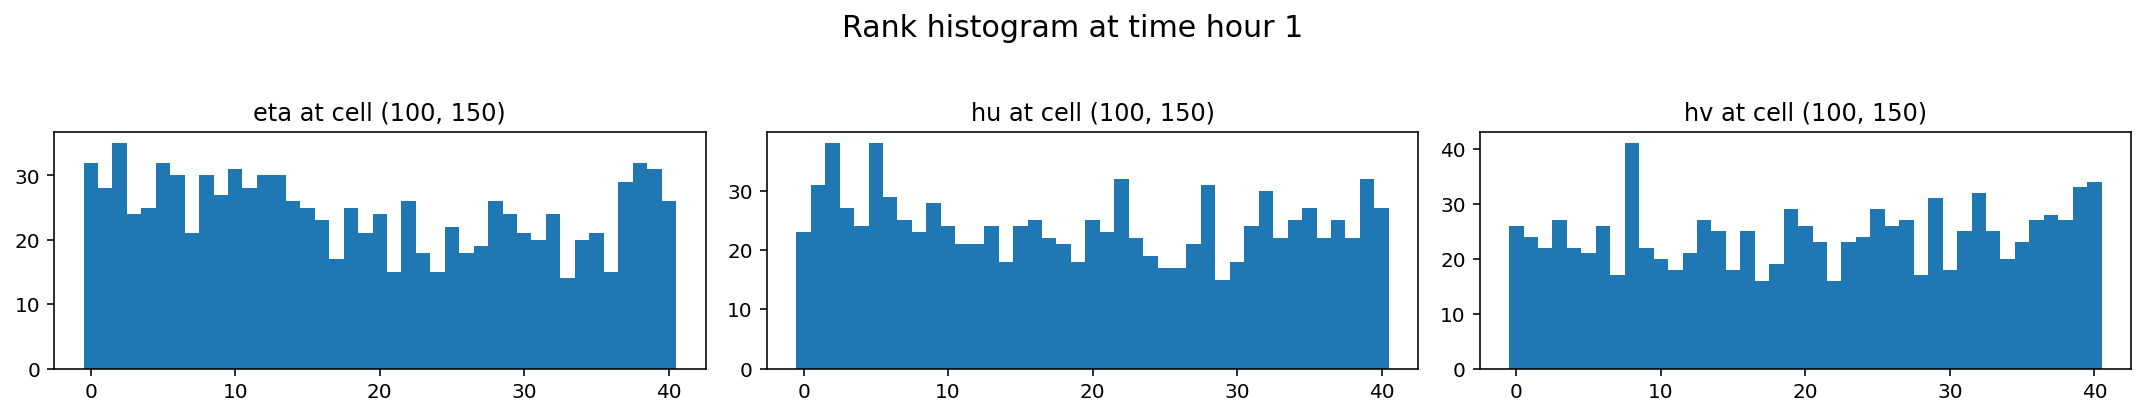

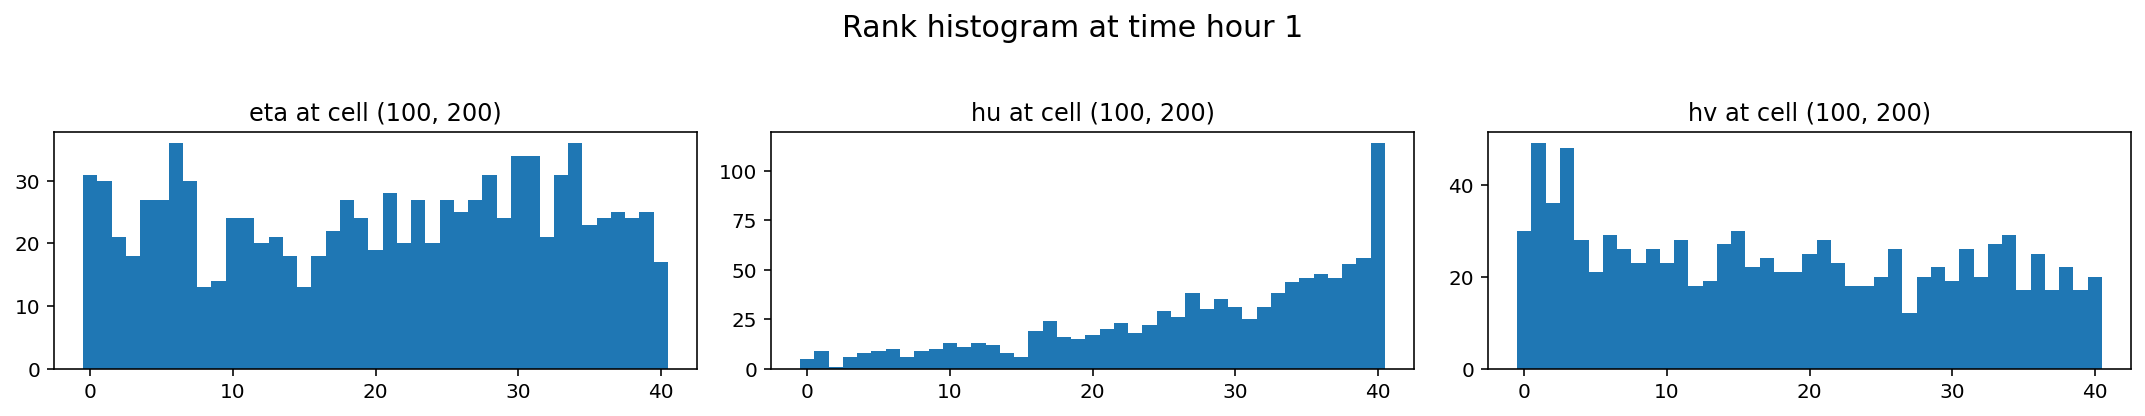

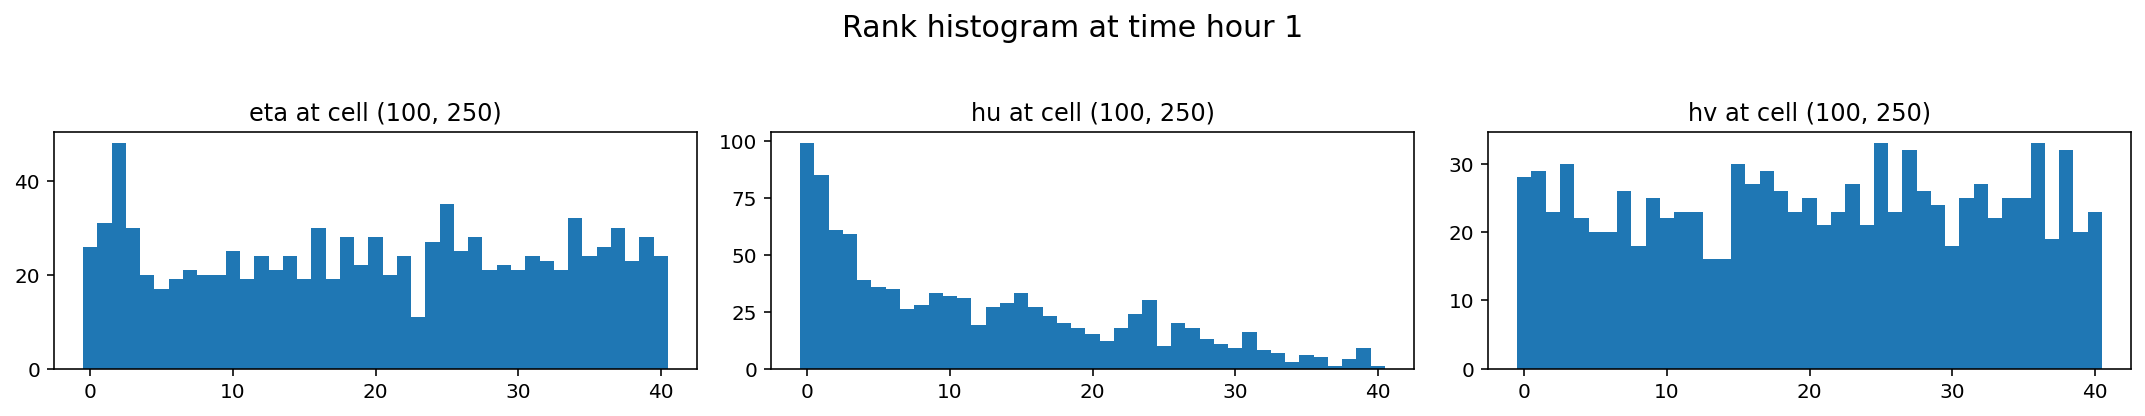

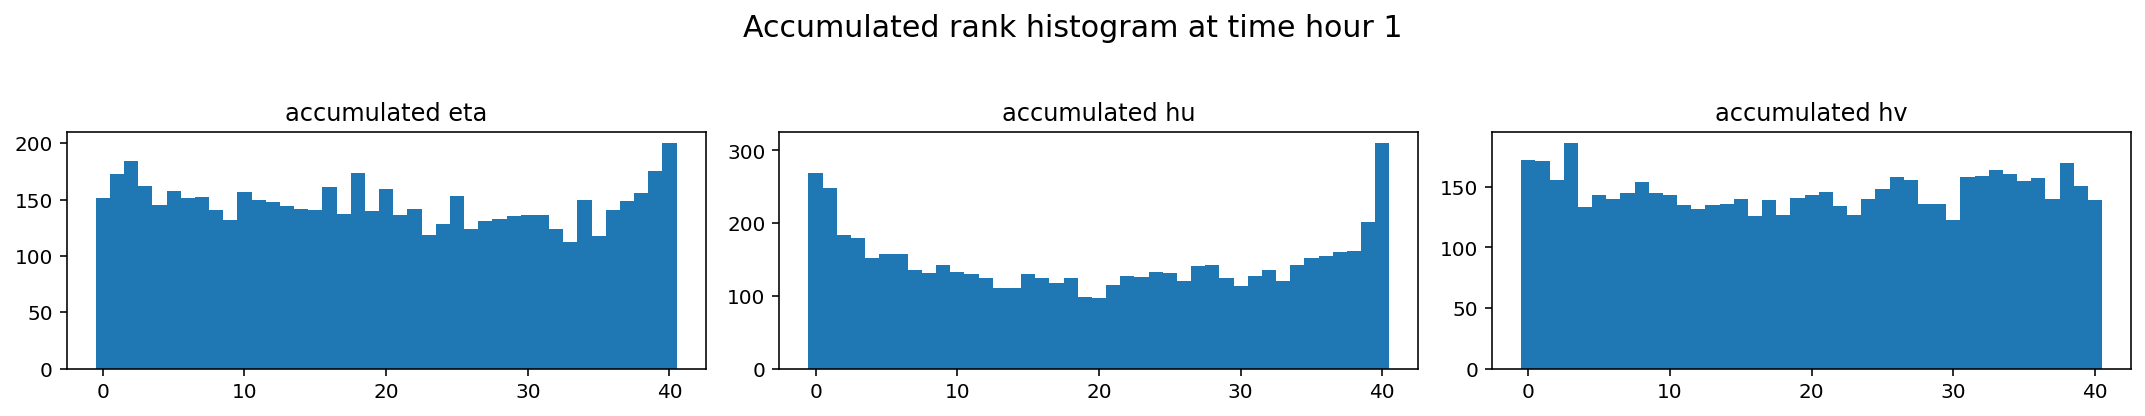

In [14]:
hour = 1
#interesting_y_indices = np.array([0, 25, 50, 70, 75, 80, 100, 125, 150, 175])
interesting_y_indices = np.array([0, 50, 100, 150, 200, 250])
print(dataset_path)
rank_hists_1_even = rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=True)  

#rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=False)  


['/sintef/rank_histogram_experiments/rank_histogram_experiments_2022_03_07-16_56_25_sparseLETKF']
Creating rank histogram from 1000 files
.0..10..20..30..40..50..60..70..80..90..100..110..120..130..140..150..160..170..180..190..200..210..220..230..240..250..260..270..280..290..300..310..320..330..340..350..360..370..380..390..400..410..420..430..440..450..460..470..480..490..500..510..520..530..540..550..560..570..580..590..600..610..620..630..640..650..660..670..680..690..700..710..720..730..740..750..760..770..780..790..800..810..820..830..840..850..860..870..880..890..900..910..920..930..940..950..960..970..980..990.

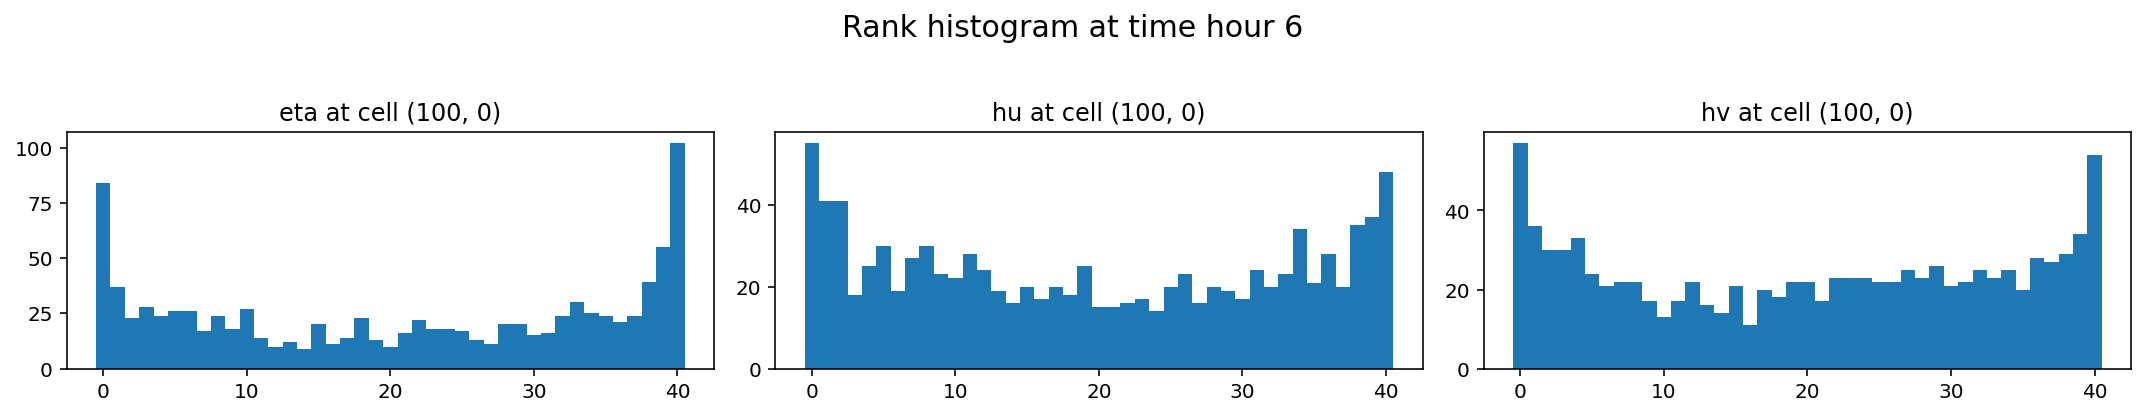

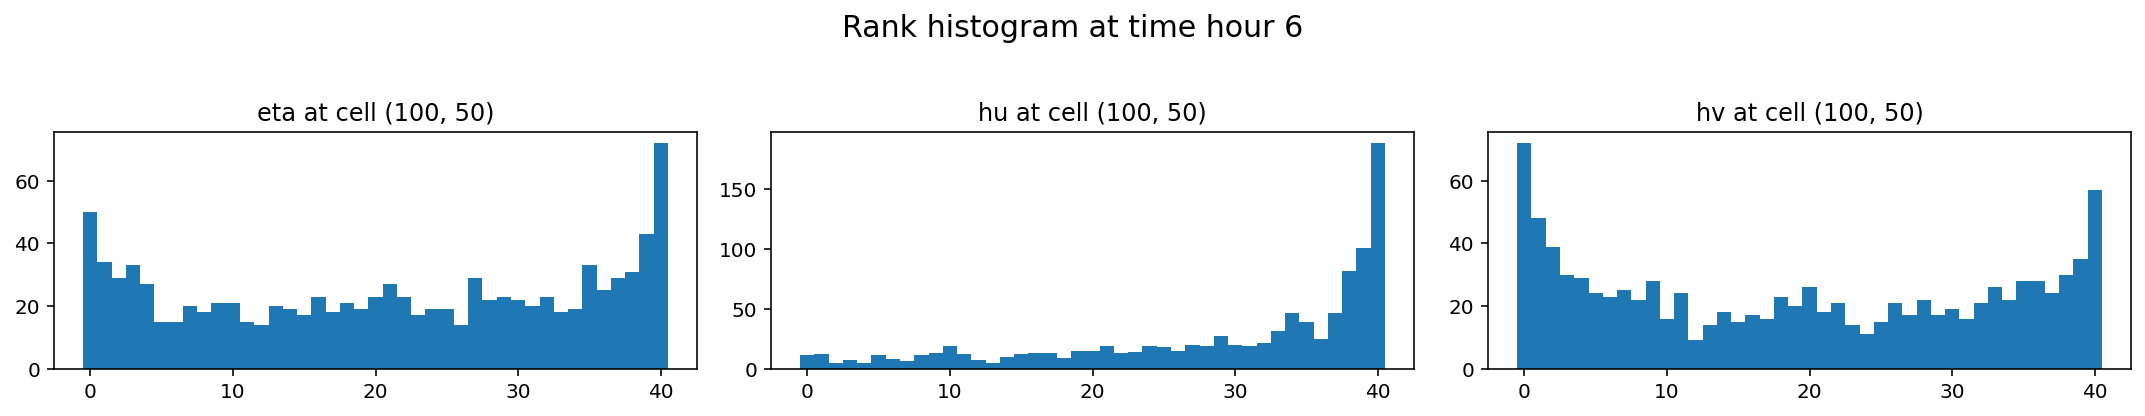

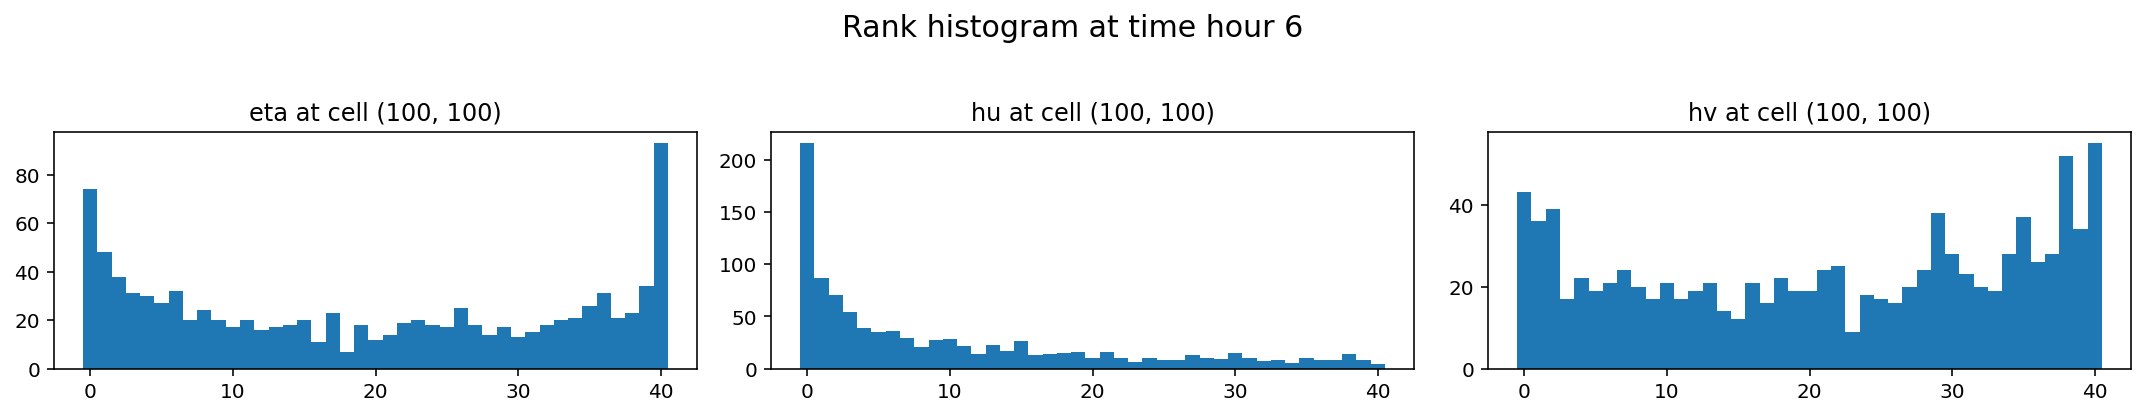

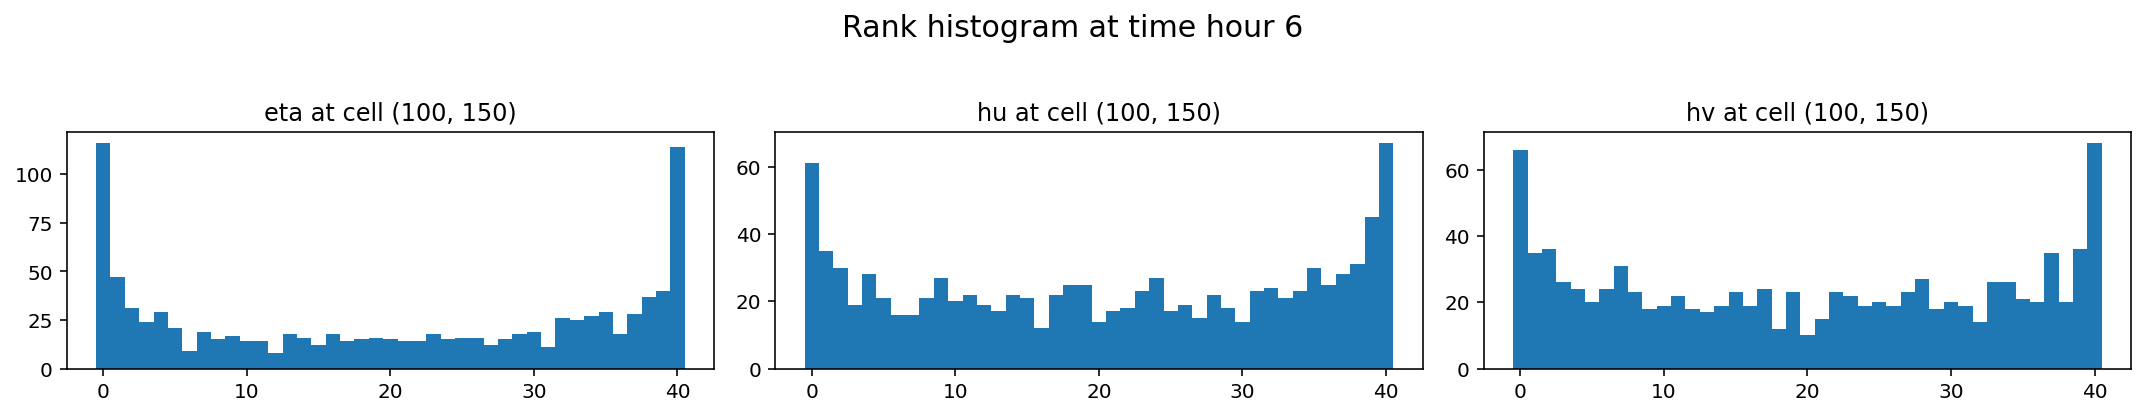

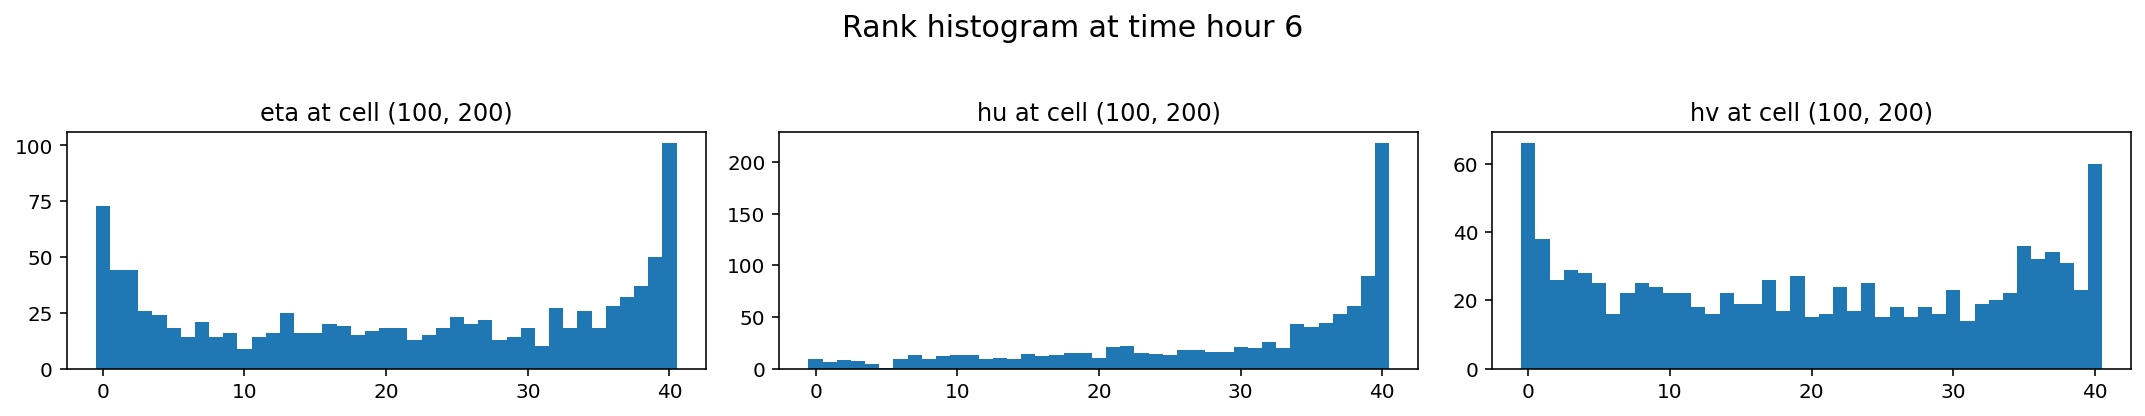

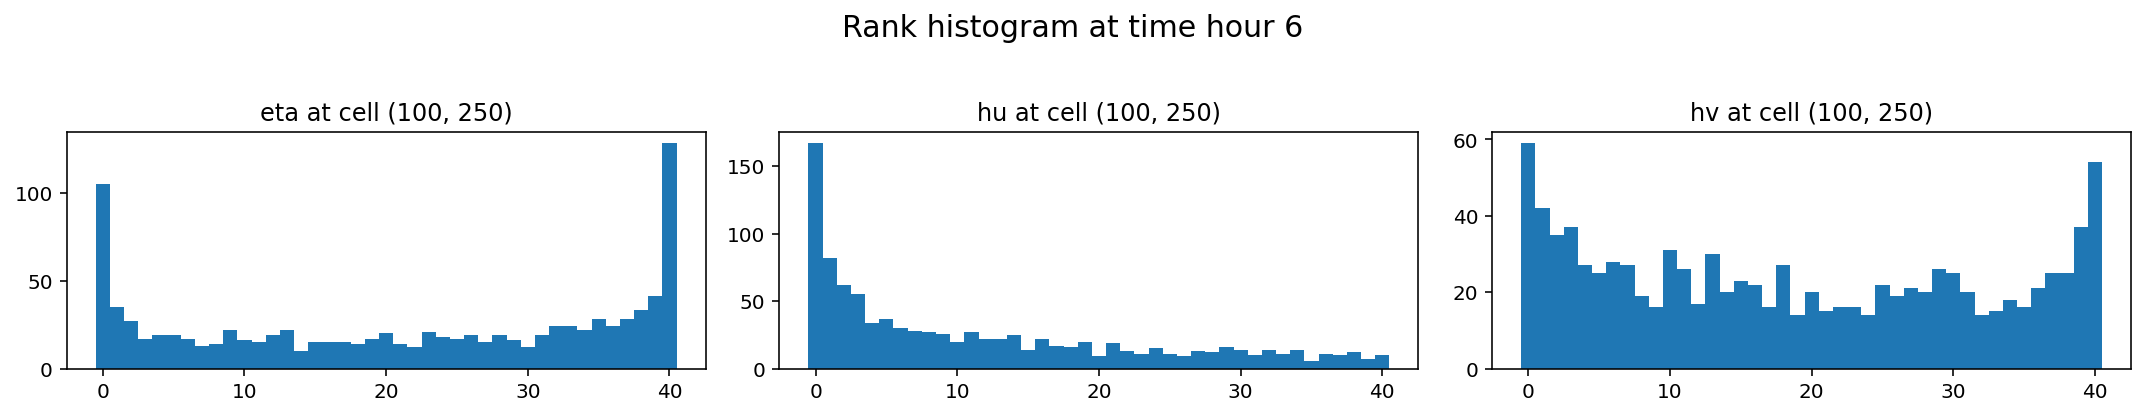

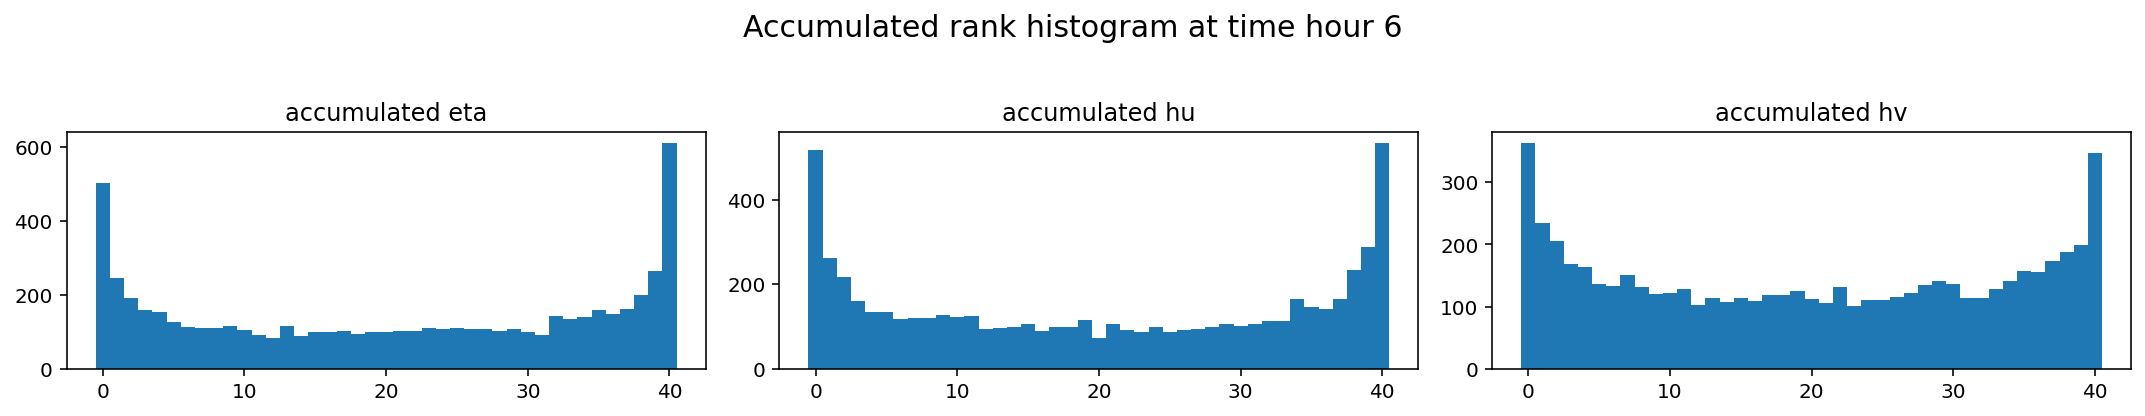

In [15]:
hour = 6
#interesting_y_indices = np.array([0, 25, 50, 70, 75, 80, 100, 125, 150, 175])
interesting_y_indices = np.array([0, 50, 100, 150, 200, 250])
print(dataset_path)
rank_hists_6_even = rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=True)  

#rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=False)  


In [16]:
# hour = 6
# #interesting_y_indices = np.array([0, 25, 50, 70, 75, 80, 100, 125, 150, 175])
# interesting_y_indices = np.array([0, 50, 100, 150, 200, 250])+25
# print(dataset_path)
# rank_hists_6_odd = rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=True)  

# #rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=False)  


In [17]:
# hour = 7
# #interesting_y_indices = np.array([0, 25, 50, 70, 75, 80, 100, 125, 150, 175])
# interesting_y_indices = np.array([0, 50, 100, 150, 200, 250])
# print(dataset_path)
# rank_hists_7_even = rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=True)  


In [18]:
# hour = 7
# interesting_y_indices = np.array([0, 37, 50])
# rankhistogram(dataset_path, hour, truth_reader, interesting_y_indices, perturb=True)  


# Plotting for paper

In [19]:
def plot_for_paper(rank_histograms, use_indices):
    
    assert(len(use_indices) == 3), 'provide three indices for the rank_histograms array to use'
    Ne = 40
    
    fig = plt.figure(figsize=(12,5))

    gs = fig.add_gridspec(2,4)
    
    def make_rank_hist(index_x, index_y, rank_hist, title):
        
        ax = fig.add_subplot(gs[index_y, index_x])
        ax.bar(np.arange(Ne+1), rank_hist, width=1, 
               #color='xkcd:dark sky blue', edgecolor='b')
               #color='xkcd:stormy blue', edgecolor='b')
               color='xkcd:bluey grey', edgecolor='b')
        
        ax.set_title(title)
        ax.set_xlabel('Rank')
        ax.set_ylabel('Frequency')
        
    print(rank_histograms[use_indices[0]]['rank_hist_hv'].shape)
        
    make_rank_hist(0,0,rank_histograms[use_indices[0]]['rank_hist_hu'], 
                   r'$hu$ at cell (100, '+str(rank_histograms[use_indices[0]]['y_cell'])+')')
    make_rank_hist(0,1,rank_histograms[use_indices[0]]['rank_hist_hv'], 
                   r'$hv$ at cell (100, '+str(rank_histograms[use_indices[0]]['y_cell'])+')')
    make_rank_hist(1,0,rank_histograms[use_indices[1]]['rank_hist_hu'], 
                   r'$hu$ at cell (100, '+str(rank_histograms[use_indices[1]]['y_cell'])+')')
    make_rank_hist(1,1,rank_histograms[use_indices[1]]['rank_hist_hv'], 
                   r'$hv$ at cell (100, '+str(rank_histograms[use_indices[1]]['y_cell'])+')')
    make_rank_hist(2,0,rank_histograms[use_indices[2]]['rank_hist_hu'], 
                   r'$hu$ at cell (100, '+str(rank_histograms[use_indices[2]]['y_cell'])+')')
    make_rank_hist(2,1,rank_histograms[use_indices[2]]['rank_hist_hv'], 
                   r'$hv$ at cell (100, '+str(rank_histograms[use_indices[2]]['y_cell'])+')')
    make_rank_hist(3,0,rank_histograms[-1]['rank_hist_hu'], 
                   r'$hu$ accumulated')
    make_rank_hist(3,1,rank_histograms[-1]['rank_hist_hv'], 
                   r'$hv$ accumulated')
    fig.tight_layout()
    
    filename = 'rank_histogram_paper.pdf'
    plt.savefig(os.path.join(fig_path, filename))
    plt.savefig(os.path.join(fig_path, filename).replace('.pdf', '.png'))

(41,)


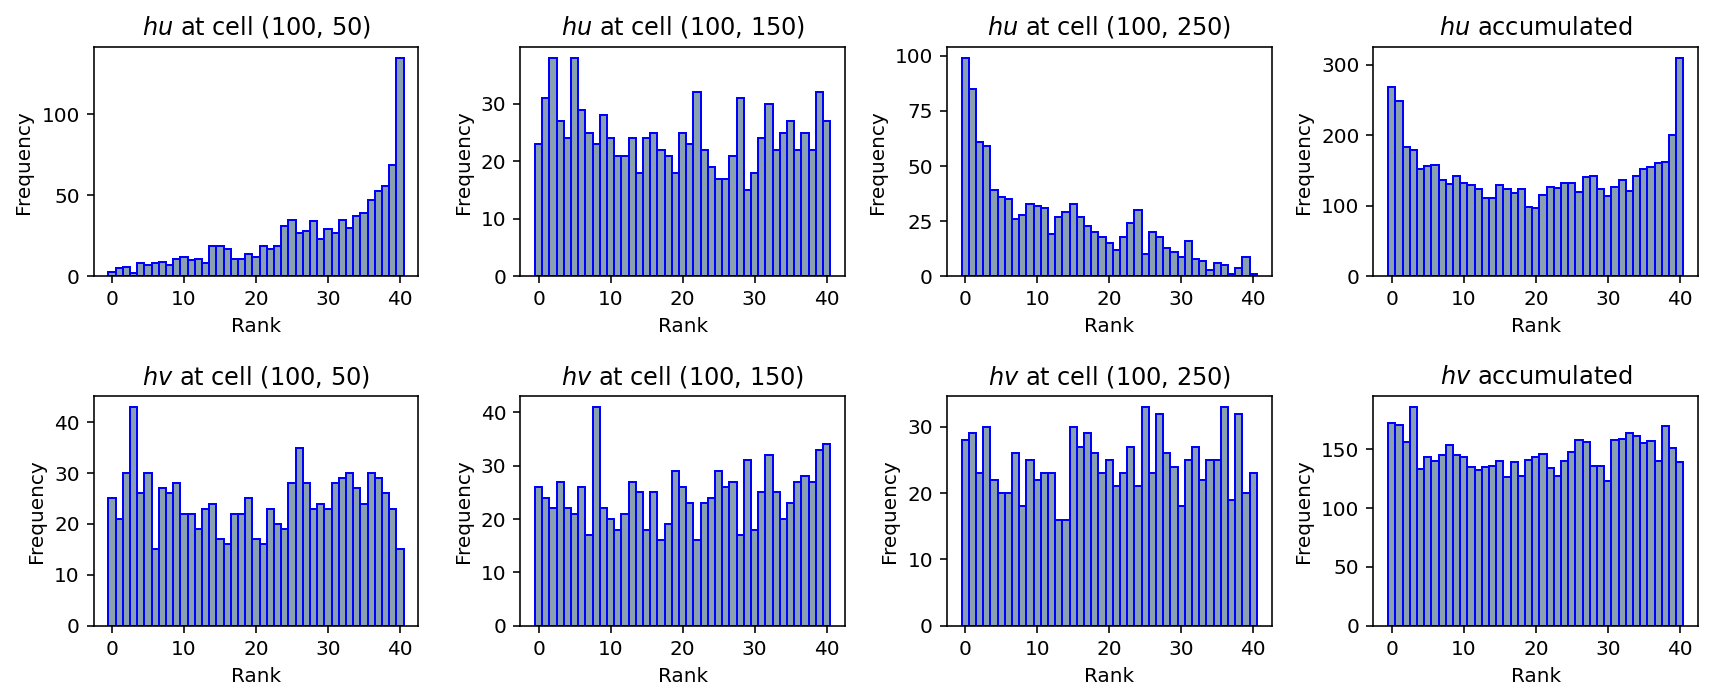

In [20]:
plot_for_paper(rank_hists_1_even, [1,3, 5])

In [21]:
print(fig_path)

/sintef/rank_histogram_experiments/rank_histogram_experiments_2022_03_07-16_56_25_sparseLETKF/figures_2022_03_09-17_33_57


In [22]:
def plot_for_pres(rank_histograms):
    
    Ne = 40
    
    fig = plt.figure(figsize=(3,6))

    gs = fig.add_gridspec(2,1)

    ref_level = np.sum(rank_histograms[-1]['rank_hist_hu'])/rank_histograms[-1]['rank_hist_hu'].shape[0]
    
    def make_rank_hist(index_x, index_y, rank_hist, title):
        
        ax = fig.add_subplot(gs[index_y, index_x])
        ax.bar(np.arange(Ne+1), rank_hist, width=1, 
               color='xkcd:bluey grey', edgecolor='b')
        
        ax.set_title(title)
        ax.set_xlabel('Rank')
        ax.set_ylabel('Frequency')
        ax.set_yticklabels([])

        ax.plot(np.arange(0,41), np.repeat(ref_level,41), "--", c="black",linewidth=2)
        
    make_rank_hist(0,0,rank_histograms[-1]['rank_hist_hu'], 
                   r'$hu$ accumulated')
    make_rank_hist(0,1,rank_histograms[-1]['rank_hist_hv'], 
                   r'$hv$ accumulated')

    
    
    fig.tight_layout()
    
    filename = 'rank_histogram_pres.pdf'
    plt.savefig(os.path.join(fig_path, filename))
    plt.savefig(os.path.join(fig_path, filename).replace('.pdf', '.png'))



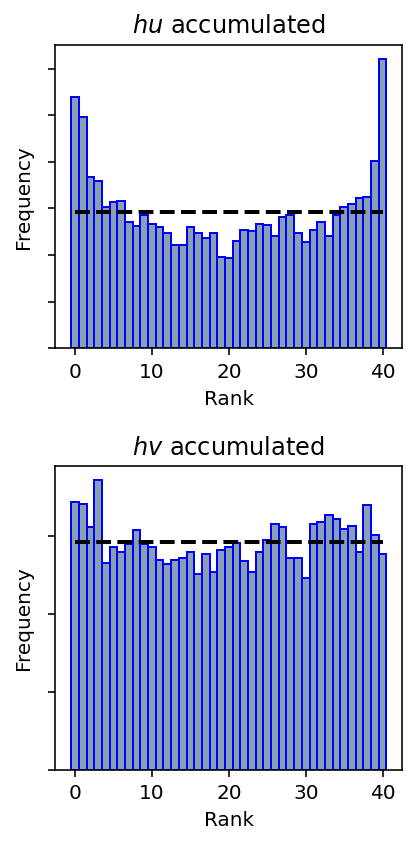

In [23]:
plot_for_pres(rank_hists_1_even)